In [7]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [8]:
X_train, X_test, y_train, y_test = X[:800], X[800:1000], y[:800], y[800:1000]

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

linear_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="linear"))
])

poly_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly"))
])

rbf_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="rbf"))
])

In [10]:
from scipy.stats import uniform, randint

param_distribs_linear = {
    "svm_clf__C": uniform(0.1, 10)
}

param_distribs_poly = {
    "svm_clf__C": uniform(0.1, 20),
    "svm_clf__degree": randint(2, 5),
    "svm_clf__coef0": uniform(0, 2)
}

param_distribs_rbf = {
    "svm_clf__C": uniform(1, 20),
    "svm_clf__gamma": uniform(0.001, 0.1)
}

In [11]:
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score

scorers = {
    'f1': make_scorer(f1_score, average='macro'),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro')
}


In [12]:
from sklearn.model_selection import RandomizedSearchCV
import time

models = {
    "Linear SVM": (linear_svm_clf, param_distribs_linear),
    "Polynomial SVM": (poly_svm_clf, param_distribs_poly),
    "RBF SVM": (rbf_svm_clf, param_distribs_rbf)
}

results = {}

for name, (model, params) in models.items():
    rnd_search = RandomizedSearchCV(
        model, params, n_iter=5, cv=3,
        scoring='f1_macro', random_state=42, n_jobs=-1
    )

    start_time = time.time()
    rnd_search.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_pred = rnd_search.best_estimator_.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    results[name] = {
        "Best Params": rnd_search.best_params_,
        "F1": f1,
        "Precision": prec,
        "Recall": rec,
        "Training Time (s)": train_time
    }

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

start_time = time.time()
knn_clf.fit(X_train, y_train)
train_time = time.time() - start_time

y_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)

precision = precision_score(y_train, y_pred, average='macro')
recall = recall_score(y_train, y_pred, average='macro')
f1 = f1_score(y_train, y_pred, average='macro')

In [14]:
results["KNN"] = {
    "Best Params": {"n_neighbors": 4, "weights": "distance"},
    "Precision": precision,
    "Recall": recall,
    "F1": f1,
    "Training Time (s)": train_time
}

Model Metrics:


,Precision,Recall,F1
Linear SVM,0.813296,0.817335,0.813827
Polynomial SVM,0.847392,0.84685,0.843739
RBF SVM,0.908266,0.477554,0.533537
KNN,0.826115,0.808181,0.810871


Best Hyperparameters:

Linear SVM:
  svm_clf__C: 3.845401188473625

Polynomial SVM:
  svm_clf__C: 15.693820005455384
  svm_clf__coef0: 1.193700315892974
  svm_clf__degree: 3

RBF SVM:
  svm_clf__C: 4.12037280884873
  svm_clf__gamma: 0.016599452033620267

KNN:
  n_neighbors: 4
  weights: distance


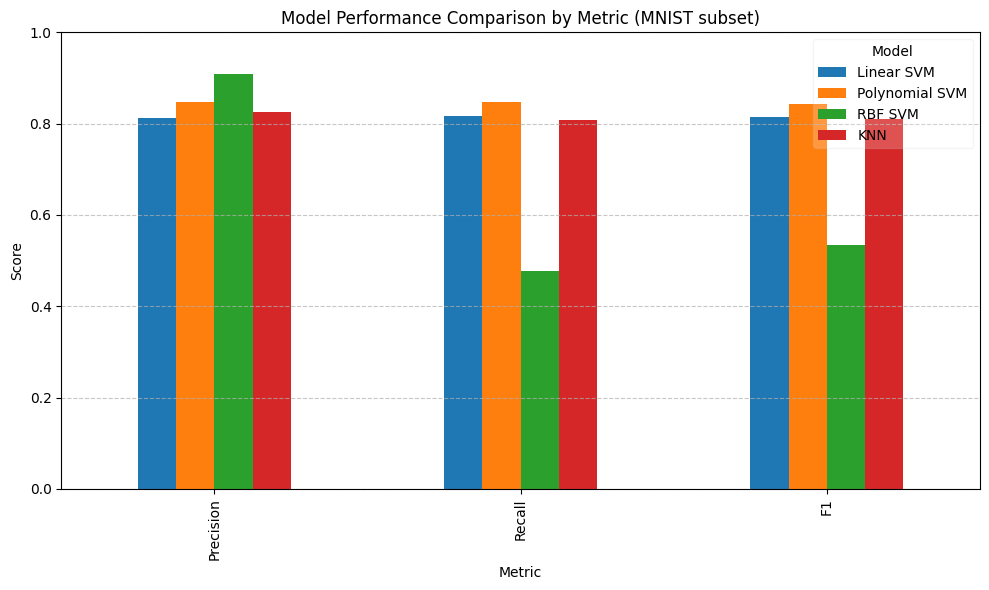

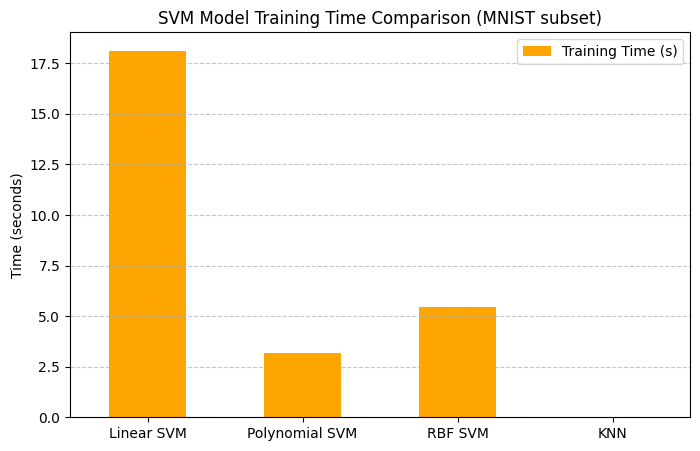

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

results_df = pd.DataFrame(results).T
metrics_df = results_df[["Precision", "Recall", "F1"]]
params_df = results_df[["Best Params"]]

print("Model Metrics:")
display(metrics_df)

print("Best Hyperparameters:")
for model, row in params_df.iterrows():
    print(f"\n{model}:")
    for k, v in row["Best Params"].items():
        print(f"  {k}: {v}")


metrics_df = results_df[["Precision", "Recall", "F1"]]

metrics_df = metrics_df.T

metrics_df.plot(
    kind='bar',
    figsize=(10, 6),
    title='Model Performance Comparison by Metric (MNIST subset)',
    stacked=False
)

plt.xlabel("Metric")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Model", framealpha=0.2)
plt.tight_layout()
plt.show()


results_df[["Training Time (s)"]].plot(kind='bar', figsize=(8,5), color='orange')
plt.title("SVM Model Training Time Comparison (MNIST subset)")
plt.ylabel("Time (seconds)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.show()